# Predicting High School Student Performance 

The dataset we are looking at was taken from the UCI Machine Learning Repository. It contains data collected from two secondary schools in Portugal via student surveys and academic performance.

## Step 1: Loading and exploring the dataset

In [1027]:
import pandas as pd
import numpy as np
# read in the datasets
port_df = pd.read_csv("student-por.csv", sep=";")
maths_df = pd.read_csv("student-mat.csv", sep=";")

## Step 2: Pre-processing

In [2]:
# Check for missing values
print(port_df.shape)
print(maths_df.shape)
print(port_df.isnull().values.any())
print(maths_df.isnull().values.any())

False


G3 (final year grade) was calculated using G1 and G2 (1st and 2nd period grades). We will use G3 as the responce variable and later on as the class variable by converitng it to a discrete scale. Since G3 is correlated with G1 and G2, the period grade variables will not be used as predictors in this analysis.

About categorical/numeric...

In [612]:
# Remove G1 and G2 
df = port_df.drop(['G1', 'G2'], axis = 1)
#df = port_df

#df.info()
#<-------------------- Convert grade to a discrete scale ---------------------->#
# Conversion intervals based on Portugal's grade classification system

'''
conditions = [
    (df['G3'] >= 0) & (df['G3'] < 7),
    (df['G3'] >= 7) & (df['G3'] < 10),
    (df['G3'] >= 10) & (df['G3'] < 14),
    (df['G3'] >= 14) & (df['G3'] < 16),
    (df['G3'] >= 16) & (df['G3'] < 18),
    (df['G3'] >= 18) & (df['G3'] <= 20)
]
choices = ['very poor', 'poor', 'sufficient', 'good', 'very good', 'excellent']
'''

# a less fragmented classification with groups lumped together

conditions = [
    (df['G3'] >= 0) & (df['G3'] < 10),
    (df['G3'] >= 10) & (df['G3'] < 16),
    (df['G3'] >= 16) & (df['G3'] <= 20)
]

choices = ['very poor to poor', 'sufficient to good', 'very good to excellent']


# corresponding grade classifications

df['G3_discrete'] = np.select(conditions, choices)

conditions_binary = [
    (df['G3'] >= 0) & (df['G3'] < 10),
    (df['G3'] >= 10) & (df['G3'] <= 20)
]

choices_binary = ['fail', 'pass']
#df['G3_binary'] = np.select(conditions_binary, choices_binary)


# No longer need numeric grade column
#df = df.drop('G3', axis=1)

#<-------------------- Treat ordinal attributes as categorical, not numeric ---------------------->#

# Get column names
attributes = list(df)
# Exclude the attributes that should be treated as numeric
attributes = [a for a in attributes if a not in ('age', 'absences', 'G3', 'G1', 'G2')]
for attribute in attributes:
    df[attribute] = df[attribute].astype('category',copy=False)

from copy import deepcopy
processed_df = deepcopy(df)

#<-------------------- Change labels to numeric values ------------------------------------------->#

# Some categorical variables are already encoded with numbers (e.g. studytime 0-4), we need to encode the rest
# df.info()
#attributes = list(df)
#labels = [a for a in attributes if a not in ('age', 'absences', 'G3')]
labels = df.select_dtypes(include=['category'])

# object-type attributes are strings - we need to recode these
#labels = df.select_dtypes(include = "object").columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for l in labels:
    df[l] = le.fit_transform(df[l].astype(str))
#print(df.head())




In [542]:

#<-------------------- Treat ordinal attributes as categorical, not numeric ---------------------->#

# Get column names
def category_converter(df):
    attributes = list(df)
    # Exclude the attributes that should be treated as numeric
    attributes = [a for a in attributes if a not in ('age', 'absences', 'G3')]
    for attribute in attributes:
        df[attribute] = df[attribute].astype('category',copy=False)
    return df


#<-------------------- Change labels to numeric values ------------------------------------------->#

# Some categorical variables are already encoded with numbers (e.g. studytime 0-4), we need to encode the rest
# df.info()
#attributes = list(df)
#labels = [a for a in attributes if a not in ('age', 'absences', 'G3')]

def label_encoder(df):
    labels = df.select_dtypes(include=['category'])

    # object-type attributes are strings - we need to recode these
    #labels = df.select_dtypes(include = "object").columns
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for l in labels:
        df[l] = le.fit_transform(df[l].astype(str))
    return df
    #print(df.head())
    
#<-------------------- One hot encoder ------------------------------------------->#


def one_hot_encoder(df):
    labels = df.select_dtypes(include=['category'])

    # object-type attributes are strings - we need to recode these
    #labels = df.select_dtypes(include = "object").columns
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for l in labels:
        df[l] = le.fit_transform(df[l].astype(str))
    return df
    #print(df.head())


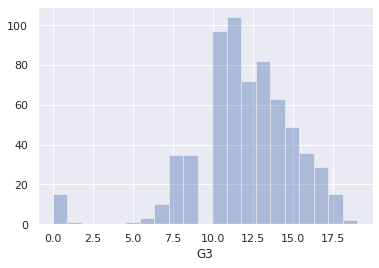

In [585]:
# check if G3 values make sense (are between 0 and 20)
import seaborn as sn
sn.set(color_codes=True)
sn.distplot(df['G3'], kde=False)

# As expected, the grade distribution is approximately bell-curved. 
# The class "sufficient to good" clearly dominates the dataset

# Need to use under-sampling



157


In [615]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

class_1 = df[df['G3_discrete'] == 1 ] 
class_0 = df[df['G3_discrete'] == 0 ].sample(len(class_1), random_state = 0)
class_2 = df[df['G3_discrete'] == 2 ].sample(len(class_1), random_state = 0) 
frames = [class_1, class_2, class_0]
balanced_sample = pd.concat(frames)

#<-------------------- Correlation-Based Feature Selection -------------------------------------->
X_cfs = balanced_sample.drop(['G3_discrete', 'G3'], axis=1)
y = balanced_sample['G3_discrete']

from skfeature.function.statistical_based import CFS
idx = CFS.cfs(X_cfs.values, y)
#df_cfs = balanced_sample.columns[idx]
df_cfs = balanced_sample.iloc[:, idx]

#<-------------------- Feature Selection (Chi-squared) -------------------------------------->
X = balanced_sample.drop(['G3_discrete','G3'], axis=1)

# for random forest
#X = balanced_sample.drop(['G3_discrete','G3_binary', 'G3', 'reason','school','Mjob','Fjob'], axis=1)

y = balanced_sample['G3_discrete']
# 14 for NB
selector = SelectKBest(chi2, k=14)
feature_data = selector.fit_transform(X, y)
mask=selector.get_support()
feature_names = X.columns[mask]
df_selected = pd.DataFrame(feature_data, columns=feature_names)

# full dataset with feature selection
df_selected_full = pd.DataFrame(feature_data, columns=feature_names)

# Now split the data into training and testing (80/20)
train_x, test_x, train_y, test_y = train_test_split(df_selected, y, stratify=y, test_size=0.2, random_state=42)
# no feature selection
# train_x, test_x, train_y, test_y = train_test_split(df.drop(['G3_discrete','G3_binary', 'G3', 'school'], axis=1), df['G3_discrete'],stratify=df['G3_discrete'], test_size=0.2, random_state=42)
#g_class = GaussianNB()

#Train the model using the training sets
#g_class.fit(train_x, train_y)

#Predict the response for test dataset
#pred_y = g_class.predict(test_x)

#cm=metrics.confusion_matrix(test_y,pred_y)
#df_cm = pd.DataFrame(cm, range(6), range(6))

#sn.set(font_scale=1.4) # for label size
#sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

#plt.show()

#np.count_nonzero(pred_y!=test_y)

#sum(train_y==2)

In [575]:
df_selected

,school,Medu,Fedu,Mjob,reason,traveltime,studytime,failures,schoolsup,higher,freetime,Dalc,Walc,absences
0,0,3,2,3,1,0,1,0,0,1,1,0,0,0
1,0,4,4,1,1,0,0,0,0,1,3,0,1,6
2,0,4,3,1,3,0,3,0,0,1,1,0,0,2
3,0,4,2,1,2,0,1,0,0,1,2,0,0,0
4,0,4,4,4,3,0,1,0,0,1,1,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,0,3,3,2,3,1,1,0,0,1,3,0,0,0
242,0,4,3,1,1,0,1,0,0,1,2,0,4,2
243,0,3,3,3,3,1,2,0,0,1,1,1,2,2
244,1,1,0,0,0,2,0,1,1,1,2,0,0,0


[2 5 5 5 4 4 4 4 2 2 5 5 5]
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        16
           1       0.77      0.59      0.67        17
           2       0.67      0.82      0.74        17

   micro avg       0.70      0.70      0.70        50
   macro avg       0.71      0.70      0.70        50
weighted avg       0.71      0.70      0.70        50

0.7


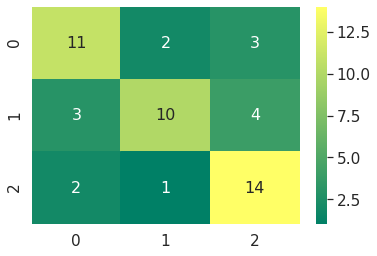

In [616]:
# already installed the package with pip install mixed-naive-bayes
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mixed_naive_bayes import MixedNB

indices=[]
attributes = list(train_x)
attributes = [a for a in attributes if a not in ('age', 'absences', 'G1', 'G2')]
#print(attributes)
#print(train_x)
for attr in attributes:
    indices.append(train_x.columns.get_loc(attr))

clf = MixedNB(categorical_features=indices)

clf.fit(train_x,train_y)
pred = clf.predict(test_x)

cm=confusion_matrix(test_y,pred)
df_cm = pd.DataFrame(cm, range(3), range(3))

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="summer") # font size


# calculate accuracy of the model
sum(pred==test_y)/len(test_y)

#best
#l=['class 0', 'class 1', 'class 2']
print(classification_report(test_y, pred))

print(sum(pred==test_y)/len(test_y))


In [825]:
# selected features
print(df_selected.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 14 columns):
school        246 non-null int64
Medu          246 non-null int64
Fedu          246 non-null int64
Mjob          246 non-null int64
reason        246 non-null int64
traveltime    246 non-null int64
studytime     246 non-null int64
failures      246 non-null int64
schoolsup     246 non-null int64
higher        246 non-null int64
freetime      246 non-null int64
Dalc          246 non-null int64
Walc          246 non-null int64
absences      246 non-null int64
dtypes: int64(14)
memory usage: 27.0 KB
None


In [848]:
from skfeature.function.statistical_based import CFS
idx = CFS.cfs(X.values, y)


array([14, 20,  0,  7, 25,  6, 10, 23, 13])

In [833]:
# Plot ROC curve
from sklearn.metrics import roc_curve, auc
'''
test_joint = pd.DataFrame(test_x, test_y, pred)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(test_y[test_y==i], pred[test_y==i])
    roc_auc[i] = auc(fpr[i], tpr[i])
'''



'\ntest_joint = pd.DataFrame(test_x, test_y, pred)\nfpr = dict()\ntpr = dict()\nroc_auc = dict()\nfor i in range(3):\n    fpr[i], tpr[i], _ = roc_curve(test_y[test_y==i], pred[test_y==i])\n    roc_auc[i] = auc(fpr[i], tpr[i])\n'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 8 to 393
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   failures   246 non-null    int64
 1   higher     246 non-null    int64
 2   school     246 non-null    int64
 3   Fedu       246 non-null    int64
 4   goout      246 non-null    int64
 5   Medu       246 non-null    int64
 6   reason     246 non-null    int64
 7   famrel     246 non-null    int64
 8   studytime  246 non-null    int64
dtypes: int64(9)
memory usage: 19.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   school      246 non-null    int64
 1   Medu        246 non-null    int64
 2   Fedu        246 non-null    int64
 3   Mjob        246 non-null    int64
 4   reason      246 non-null    int64
 5   traveltime  246 non-null    int64
 6   studytime   

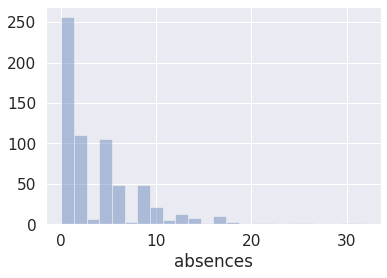

In [23]:
# Comments on NB assumptions
#sn.distplot(df['age'], kde=False)
print(df_cfs.info())
print(df_selected.info())

sn.distplot(df['absences'], kde=False)

## Random forest

In [926]:
#df['col_name'] = df['col_name'].astype('category')

#print(sum(predictions==test_y)/len(test_y))
# Calculate the absolute errors
#errors = abs(predictions - test_y)
# Print out the mean absolute error (mae)
#print('Mean Absolute Error:', round(np.mean(errors), 2))
#predictions
#for p in predictions:
#    p = np.round(p)
    
#predictions = [np.round(p) for p in predictions]
print(sum(predictions==test_y)/len(test_y))
#predictions
'''
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# 
from sklearn.tree import export_graphviz

# sudo apt install python-pydot python-pydot-ng graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot',  rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('tree.png')
plt.imshow(img)
plt.show()
'''

0.0


"\n# Import tools needed for visualization\nfrom sklearn.tree import export_graphviz\nimport pydot\n# Pull out one tree from the forest\ntree = rf.estimators_[5]\n# \nfrom sklearn.tree import export_graphviz\n\n# sudo apt install python-pydot python-pydot-ng graphviz\nimport pydot\n# Pull out one tree from the forest\ntree = rf.estimators_[5]\n# Export the image to a dot file\nexport_graphviz(tree, out_file = 'tree.dot',  rounded = True, precision = 1)\n# Use dot file to create a graph\n(graph, ) = pydot.graph_from_dot_file('tree.dot')\n# Write graph to a png file\ngraph.write_png('tree.png')\n\nimport matplotlib.pyplot as plt\nimport matplotlib.image as mpimg\n\nimg = mpimg.imread('tree.png')\nplt.imshow(img)\nplt.show()\n"

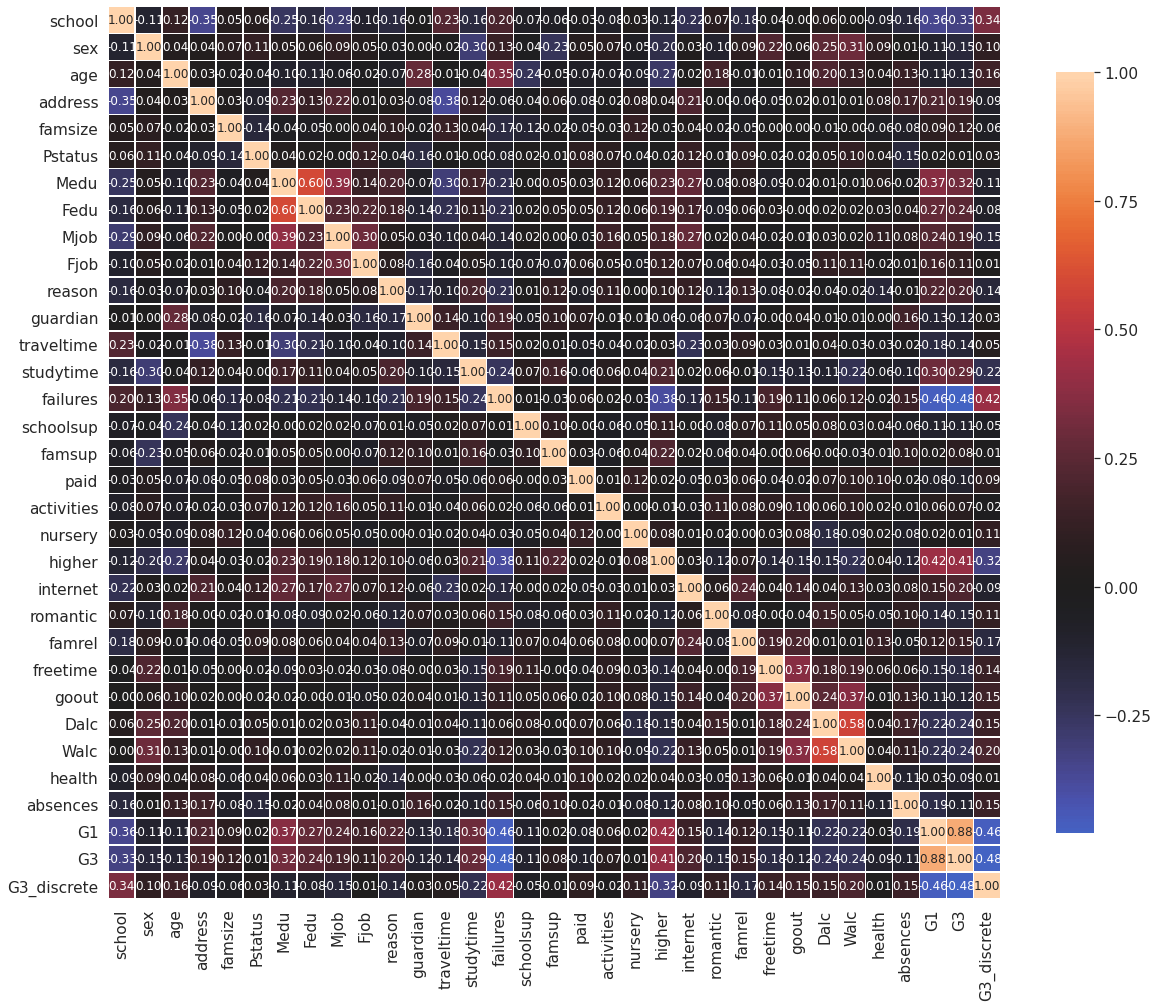

In [608]:
'''
corr = df_selected.corr()
ax = sn.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sn.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    #rotation=45,
    #horizontalalignment='right'
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    #rotation=45,
    horizontalalignment='right'
);
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70},  annot_kws={"size": 12})
    plt.show();
    
correlation_heatmap(pd.concat([balanced_sample], axis=1, sort=False))

In [562]:
# recode into binary

### No feature selection
#rf_df = balanced_sample.drop(['G3_discrete', 'G3_binary', 'G3'], axis=1)

####### balanced with feature selection
rf_df = df_selected
y = balanced_sample['G3_discrete']
### whole without feature selection
#rf_df = df.drop(['G3_discrete','G3'], axis=1)
#y = df['G3_discrete']
### balanced no fs
#rf_df = balanced_sample.drop(['G3_discrete', 'G3'], axis=1)
#y = balanced_sample['G3_discrete']

#attributes = list(rf_df)
#attributes = [a for a in attributes if a not in ('age', 'absences', 'G3_discrete')]
#labels = rf_df.select_dtypes(include=['category'])
#attributes
#ohe = OneHotEncoder()
#for l in labels:
#    rf_df[l] = ohe.fit_transform(rf_df[l].astype(str))
#rf_df 
#rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

#rf_df = pd.get_dummies(rf_df, prefix=attributes, columns=attributes) 
#rf_df['G3_discrete'] = le.fit_transform(rf_df['G3_discrete'].astype(str))
#rf_class= pd.factorize(rf_df['G3_discrete'])
#print(rf_df)

#X = rf_df.drop(['G3_discrete', 'G3_binary'], axis=1)
#y = rf_df['G3_discrete']
#X = rf_df.drop(['G3_discrete'], axis=1)
#y = rf_df['G3_discrete']
train_x, test_x, train_y, test_y = train_test_split(rf_df, y, test_size=0.2, stratify = y, random_state=42)
#rf.fit(train_x, train_y);
#predictions = rf.predict(test_x)
#print(sum(predictions==test_y)/len(test_y))
# Calculate the absolute errors
#errors = abs(predictions - test_y)
# Print out the mean absolute error (mae)
#print('Mean Absolute Error:', round(np.mean(errors), 2))
#predictions
#for p in predictions:
#    p = np.round(p)
    
#predictions = [np.round(p) for p in predictions]
#
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:53: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


In [569]:
#from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Using information gain (entropy) to evaluate how good a particular split is
classifier = RandomForestClassifier(n_estimators = 1100, min_samples_leaf= 1,
 min_samples_split= 4, max_depth=3, random_state = 42)
classifier.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=1100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [570]:
#predictions

predictions = classifier.predict(test_x)

print(sum(predictions==test_y)/len(test_y))



0.84


              precision    recall  f1-score   support

           0       0.75      0.75      0.75        16
           1       0.94      0.88      0.91        17
           2       0.83      0.88      0.86        17

   micro avg       0.84      0.84      0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50



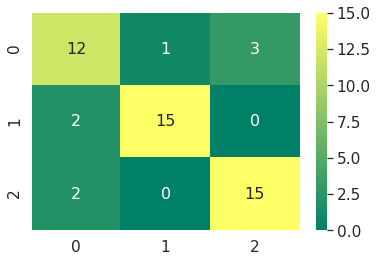

In [571]:
cm=confusion_matrix(test_y,predictions)
df_cm = pd.DataFrame(cm, range(3), range(3))

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="summer") # font size

print(classification_report(test_y, predictions))


In [249]:
df_selected

,school,sex,address,Medu,Fedu,Mjob,reason,traveltime,studytime,failures,schoolsup,paid,higher,romantic,famrel,freetime,goout,Dalc,Walc,absences
0,0,1,1,3,2,3,1,0,1,0,0,0,1,0,3,1,1,0,0,0
1,0,0,1,4,4,1,1,0,0,0,0,0,1,0,3,3,3,0,1,6
2,0,1,1,4,3,1,3,0,3,0,0,0,1,0,3,1,1,0,0,2
3,0,0,1,4,2,1,2,0,1,0,0,0,1,0,3,2,2,0,0,0
4,0,1,1,4,4,4,3,0,1,0,0,0,1,0,2,1,1,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,0,0,1,3,3,2,3,1,1,0,0,0,1,0,3,3,4,0,0,0
242,0,0,1,4,3,1,1,0,1,0,0,0,1,0,3,2,4,0,4,2
243,0,0,0,3,3,3,3,1,2,0,0,1,1,1,3,1,0,1,2,2
244,1,1,0,1,0,0,0,2,0,1,1,0,1,0,3,2,1,0,0,0


In [196]:
# Hyperparameter tuning with Random Hyperparameter Grid
from sklearn.model_selection import RandomizedSearchCV
criterion = ['entropy', 'gini']
# number of trees - 1000 seems to work well from just manual plugging in, anything below isn't good
n_estimators = [int(x) for x in np.linspace(start = 900, stop = 2000, num = 12)]
max_features = ['sqrt', 'log2', 'auto']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
#also evaluate having no limit on tree depth
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]


random_grid = {'n_estimators': n_estimators,
               'criterion' : criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [194]:
print(random_grid)

{'n_estimators': [900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000], 'criterion': ['entropy', 'gini'], 'max_features': ['sqrt', 'log2', 'auto'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [200]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
cv = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = cv, param_distributions = random_grid, n_iter = 1000, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_x, train_y)

Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed: 41.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=2500, n_jobs=-1,
          param_distributions={'n_estimators': [900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000], 'criterion': ['entropy', 'gini'], 'max_features': ['sqrt', 'log2', 'auto'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          retur

In [201]:
base_model = RandomForestClassifier(n_estimators = 1000, random_state = 42)
base_model.fit(train_x, train_y)
predictions_base = base_model.predict(test_x)

best_model = rf_random.best_estimator_
predictions_best = best_model.predict(test_x)



print(sum(predictions_base==test_y)/len(test_y)) 
print(sum(predictions_best==test_y)/len(test_y)) 


0.62
0.64


In [204]:
rf_random.best_params_



{'n_estimators': 1300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'criterion': 'gini',
 'bootstrap': False}

In [222]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [1000, 1100, 1200, 1300],
    'min_samples_leaf': [1,2,3, 4],
    'min_samples_split': [2, 3, 4],
   # 'max_features': [2, 3],
    'max_depth': [2,3,4]
    #'bootstrap': [False],
    #'criterion': ['gini'] 
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(train_x, train_y)


Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  1.7min finished


{'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 1100}

In [235]:
grid_search.best_params_

{'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 1100}

In [240]:
predictions = grid_search.predict(test_x)

In [242]:
print(sum(predictions==test_y)/len(test_y)) 


0.68


In [389]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


dat = np.array(df.drop(['G3','G3_binary', 'G3_discrete'], axis =1).astype(float))
y = np.array(df['G3_discrete'])

scaler = MinMaxScaler()
dat = scaler.fit_transform(dat)

kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
kmeans.fit(dat)
#kmeans.labels_
#kmeans.predict([[0, 0], [12, 3]])

#kmeans.cluster_centers_

correct = 0
for i in range(len(dat)):
    predict_me = np.array(dat[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = kmeans.predict(predict_me)
    
    if prediction[0] == y[i]:
        correct += 1

print(correct/len(dat))

0.26040061633281975


In [390]:
print(kmeans.labels_)


[2 2 2 2 2 1 1 2 1 1 2 2 1 1 1 2 2 2 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 2 1
 1 2 2 2 1 1 1 2 2 2 1 1 2 2 2 1 2 2 2 2 1 1 2 2 2 2 2 2 2 1 2 2 2 1 1 2 1
 2 1 1 2 1 2 1 1 2 1 2 2 2 2 1 1 2 2 2 2 1 2 1 2 2 2 1 1 1 2 1 2 2 1 1 2 1
 2 2 1 1 1 1 1 1 1 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 2 0 2 0 2 0 0 1 2 0 2 1 2
 0 1 2 1 1 2 2 1 2 2 2 2 0 1 1 1 1 2 1 2 1 1 0 0 1 1 1 1 1 1 0 1 1 2 2 2 1
 1 1 2 2 1 2 1 1 1 1 1 2 2 2 1 1 1 2 0 2 2 1 1 1 2 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 2 1 2 2 2 1 2 2 2 2 2 1 2 2 2 1 1 2 2 1 1 1 1 1 1 2 2 2 2 2 1 1 2
 2 2 0 2 1 2 0 2 1 1 1 1 2 0 2 2 2 1 2 1 1 1 1 1 1 1 0 1 1 2 2 2 1 2 2 0 1
 1 0 2 2 2 1 1 2 2 1 1 1 2 1 2 2 2 2 0 2 2 2 0 1 2 2 2 1 1 1 1 2 2 2 2 1 2
 2 1 1 1 2 2 1 1 2 2 2 1 2 1 2 2 2 1 1 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 0
 2 2 2 2 2 2 2 1 1 1 2 2 2 1 0 0 2 1 2 2 0 2 2 2 2 1 1 2 2 2 1 1 2 2 2 2 2
 2 1 1 2 1 2 1 2 2 1 2 1 1 2 2 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1
 0 0 1 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [424]:
# Random forest with H2O
import h2o
from h2o.estimators import H2ORandomForestEstimator
h2o.init()


model = H2ORandomForestEstimator(ntrees=1000, max_depth=20,sample_rate=1)


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,18 hours 30 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.5
H2O_cluster_version_age:,"7 days, 10 hours and 19 minutes"
H2O_cluster_name:,H2O_from_python_azureuser_wm29mm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.569 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [581]:
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o import H2OFrame
#from h2o import splitFrame

data = processed_df.drop(['G3'], axis = 1)


class_0 = data[data['G3_discrete'] == 'very good to excellent']
class_2 = data[data['G3_discrete'] == 'very poor to poor' ].sample(len(class_0), random_state = 0) 
class_1 = data[data['G3_discrete'] == 'sufficient to good' ].sample(len(class_0), random_state = 0)

frames = [class_1, class_2, class_0]
balanced = pd.concat(frames)

# feature selection
X = balanced_sample.drop(['G3_discrete', 'G3'], axis=1)
y = balanced['G3_discrete']
selector = SelectKBest(chi2, k=14)
feature_data = selector.fit_transform(X, y)
mask=selector.get_support()
feature_names = X.columns[mask]

balanced = pd.DataFrame(balanced, columns=feature_names)
balanced = pd.concat([balanced, y], axis=1, sort=False)

attributes = list(balanced)
training_columns = [a for a in attributes if a not in ('G3_discrete')]
# Output parameter train against input parameters
response_column = 'G3_discrete'

data_s=h2o.H2OFrame(balanced)
train, test = data_s.split_frame(ratios=[0.8])

# Train model
model.train(x=training_columns, y=response_column, training_frame=train)

Parse progress: |█████████████████████████████████████████████████████████| 100%


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


drf Model Build progress: |███████████████████████████████████████████████| 100%


In [582]:
performance = model.model_performance(test_data=test)

In [583]:
#balanced.groupby('G3_discrete').count()
#train
#response_column
#balanced
performance


ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.12477109844109208
RMSE: 0.35322952657031953
LogLoss: 0.41883422192620395
Mean Per-Class Error: 0.1878787878787879

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,sufficient to good,very good to excellent,very poor to poor,Error,Rate
0,14.0,4.0,4.0,0.363636,8 / 22
1,0.0,20.0,0.0,0.000000,0 / 20
2,3.0,0.0,12.0,0.200000,3 / 15
3,17.0,24.0,16.0,0.192982,11 / 57



Top-3 Hit Ratios: 


,k,hit_ratio
0,1,0.807018
1,2,0.982456
2,3,1.000000


In [1001]:


from sklearn.metrics import mean_squared_error
from math import sqrt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import InputLayer
from keras.utils import to_categorical 

#X = df_selected.values
#y = balanced_sample['G3_discrete'].values

X = balanced_sample.drop(['G3_discrete','G3'], axis=1).values
y = balanced_sample['G3_discrete'].values
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y, shuffle=True)

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

#train_y = to_categorical(train_y)
#test_y = to_categorical(test_y)


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [1024]:
# Create a linear stack of layers model, no shared layers
from tensorflow.keras import regularizers
from keras.regularizers import l1,l2
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.normalization import BatchNormalization

model = Sequential()
## Construct a network with one inpit layer, two hidden layers and one output layer
model.add(Dense(62, kernel_regularizer=l2(0.01), activation='relu', input_dim=30))
#model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(62, kernel_regularizer=l2(0.01), activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(30, kernel_regularizer=l2(0.01), activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer (3 nodes for the 3 outcomes)
# Ooftmax function returns probability of belonging to a class 
model.add(Dense(3, activation='softmax'))
#model.add(BatchNormalization())


# 
optimizer = keras.optimizers.Adam(lr=0.05)

# To compile the model, use sparse_categorical_crossentropy for minimisation as we have numeric multiclass labels (not binary)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [1025]:
#callbacks = [EarlyStopping(monitor='val_loss', patience=4)]
model.fit(train_x, train_y, epochs=30, validation_split=0.3)
pred_train= model.predict(train_x)
scores = model.evaluate(train_x, train_y, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   

pred_test= model.predict(test_x)
scores2 = model.evaluate(test_x, test_y, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1])) 


Train on 137 samples, validate on 59 samples
Epoch 1/30
137/137 [==============================] - ETA: 0s - loss: 2.5835 - accuracy: 0.40 - 0s 2ms/step - loss: 2.4931 - accuracy: 0.4015 - val_loss: 2.2886 - val_accuracy: 0.6102
Epoch 2/30
137/137 [==============================] - ETA: 0s - loss: 2.0266 - accuracy: 0.53 - 0s 84us/step - loss: 2.0449 - accuracy: 0.5839 - val_loss: 2.0946 - val_accuracy: 0.6271
Epoch 3/30
137/137 [==============================] - ETA: 0s - loss: 1.8680 - accuracy: 0.75 - 0s 82us/step - loss: 1.9531 - accuracy: 0.5693 - val_loss: 2.0853 - val_accuracy: 0.3898
Epoch 4/30
137/137 [==============================] - ETA: 0s - loss: 1.8870 - accuracy: 0.43 - 0s 101us/step - loss: 1.7741 - accuracy: 0.6058 - val_loss: 1.8240 - val_accuracy: 0.5593
Epoch 5/30
137/137 [==============================] - ETA: 0s - loss: 1.5472 - accuracy: 0.68 - 0s 83us/step - loss: 1.4968 - accuracy: 0.6788 - val_loss: 1.8257 - val_accuracy: 0.5763
Epoch 6/30
137/137 [==========

In [869]:
from sklearn.model_selection import KFold 

model = Sequential()
params = {'activation': ["relu", "tanh"],
          'batch_size': [16, 32, 64], 
          'epochs': [50, 100],
          'learning_rate': [0.01, 0.001, 0.0001]}
# Create a randomize search cv object 
random_search = RandomizedSearchCV(model,
                                   param_distributions = params,
                                   cv = KFold(10))
random_search_results = random_search.fit(train_x, train_y)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x7fa87ba95470> does not.

In [742]:
test_x.shape

(50, 30)

In [743]:
train_y

array([2, 0, 2, 0, 0, 1, 2, 0, 2, 2, 1, 2, 2, 0, 2, 1, 0, 2, 2, 0, 2, 2,
       1, 2, 1, 2, 2, 2, 1, 1, 2, 0, 2, 1, 0, 2, 0, 2, 1, 1, 1, 1, 1, 0,
       1, 2, 0, 0, 1, 2, 2, 0, 1, 1, 2, 2, 1, 0, 1, 0, 2, 0, 2, 1, 1, 1,
       1, 2, 2, 2, 0, 2, 2, 0, 0, 2, 1, 2, 1, 2, 2, 1, 0, 1, 0, 1, 2, 1,
       2, 0, 2, 1, 2, 2, 0, 0, 1, 0, 1, 1, 2, 1, 2, 1, 0, 0, 1, 1, 0, 1,
       2, 0, 2, 1, 2, 0, 1, 2, 1, 2, 0, 0, 0, 1, 2, 1, 1, 0, 1, 0, 2, 2,
       2, 0, 0, 2, 1, 1, 1, 0, 2, 1, 0, 1, 0, 2, 0, 0, 1, 1, 2, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 0, 2, 0, 0, 0, 2, 1, 2, 0, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 0, 1, 0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 0, 2])